In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import cv2
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data_root_path = '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023'

dir_train = []

for dir in os.listdir(data_root_path):
    dir_train.append(os.path.join(data_root_path,dir))

dir_train = sorted(dir_train)

In [3]:
dir_train

['/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-07',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-08',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-09',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-10',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-11',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-12',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-13',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-14',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-15',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-datas

In [4]:
def parse_filename(filename):
    base = os.path.basename(filename)
    name = base.split('.jpg')[0] 
    time_str, radiation = name.split('_')
    dt = datetime.strptime(time_str, '%Y-%m-%d-%H-%M-%S')
    return dt, float(radiation)

data = []
for dir in dir_train:
    for file in os.listdir(dir):
        if file.endswith('.jpg'):
            dt, radiation = parse_filename(file)
            data.append({'datetime': dt, 'radiation': radiation, 'filename':os.path.join(dir,file)})


df = pd.DataFrame(data).sort_values('datetime')

In [5]:
len(df)

68708

In [6]:
df.head()

,datetime,radiation,filename
785,2023-09-07 05:00:06,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
4723,2023-09-07 05:00:16,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
5662,2023-09-07 05:00:26,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
1268,2023-09-07 05:00:36,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
1202,2023-09-07 05:00:46,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...


In [7]:
df.isnull().sum()

datetime     0
radiation    0
filename     0
dtype: int64

# ***VISUALIZE DATA***

In [8]:
start = '2023-09-07 05:00:06'
end = '2023-09-18 19:57:53'
df_filtered = df[(df['datetime'] >= start) & (df['datetime'] <= end)]

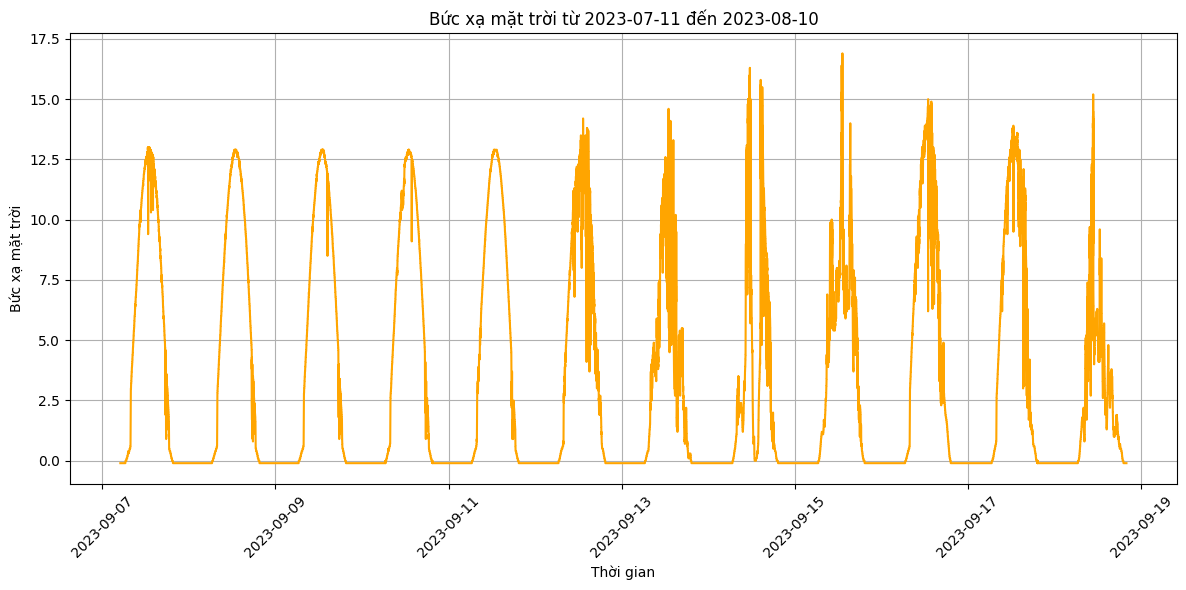

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['datetime'], df_filtered['radiation'],color = 'orange')
plt.title('Bức xạ mặt trời từ 2023-07-11 đến 2023-08-10')
plt.xlabel('Thời gian')
plt.ylabel('Bức xạ mặt trời')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.to(device)
resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
def extract_image_features(path, cache_dir="feature_cache"):
    os.makedirs(cache_dir, exist_ok=True)

    filename = os.path.basename(path)
    feature_path = os.path.join(cache_dir, filename + ".npy")

    if os.path.exists(feature_path):
        return np.load(feature_path)

    # Nếu chưa có, trích xuất và lưu lại
    image = Image.open(path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(image_tensor).squeeze().cpu().numpy()

    np.save(feature_path, features)
    return features

In [14]:
class RadiationDataset(Dataset):
    def __init__(self, df, sequence_length=6, predict_after=12):
        self.seq_len = sequence_length
        self.predict_after = predict_after
        self.features = []
        self.targets = []

        max_index = len(df) - (sequence_length + predict_after)
        for i in tqdm(range(max_index)):

            seq_paths = df.loc[i:i+sequence_length-1, "filename"]
            seq_feats = [extract_image_features(p) for p in seq_paths]

            target = df.loc[i + sequence_length + predict_after - 1, "radiation"]

            self.features.append(np.stack(seq_feats))
            self.targets.append(target)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y


In [15]:
train_ratio = 0.8
cutoff = int(len(df) * train_ratio)

df_train = df.iloc[:cutoff].reset_index(drop=True)
df_val = df.iloc[cutoff:].reset_index(drop=True)

In [16]:
len(df_train),len(df_val)

(54966, 13742)

In [17]:
df_val.head()

,datetime,radiation,filename
0,2023-09-16 13:46:25,9.6,/kaggle/input/sky-images-and-solar-radiation-m...
1,2023-09-16 13:46:35,8.6,/kaggle/input/sky-images-and-solar-radiation-m...
2,2023-09-16 13:46:45,8.1,/kaggle/input/sky-images-and-solar-radiation-m...
3,2023-09-16 13:46:55,8.6,/kaggle/input/sky-images-and-solar-radiation-m...
4,2023-09-16 13:47:05,10.7,/kaggle/input/sky-images-and-solar-radiation-m...


In [18]:
sequence_length = 6

train_dataset = RadiationDataset(df_train, sequence_length=sequence_length)
val_dataset = RadiationDataset(df_val, sequence_length=sequence_length)

100%|██████████| 13724/13724 [03:37<00:00, 62.99it/s]


In [19]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [20]:
batch_images, batch_labels = next(iter(train_loader))
print(f"Batch shape: {batch_images.shape}, Labels shape: {batch_labels.shape}")

Batch shape: torch.Size([16, 6, 512]), Labels shape: torch.Size([16])


In [21]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)          # (batch, seq_len, d_model)
        x = self.transformer(x)        # giữ nguyên batch_first=True
        x = x[:, -1, :]                # lấy output tại thời điểm cuối cùng
        return self.fc(x)   # (batch,)



In [22]:
model = TimeSeriesTransformer(input_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ***TRAINNING AND VALIDATION***

In [23]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # ==== TRAIN ====
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = criterion(pred, batch_y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    y_preds, y_trues = [], []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            loss = criterion(pred, batch_y.unsqueeze(1))
            val_loss += loss.item()
            y_preds.extend(pred.cpu().numpy())
            y_trues.extend(batch_y.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 | Train Loss: 1.3307 | Val Loss: 1.4018
Epoch 2/10 | Train Loss: 0.5925 | Val Loss: 1.3782
Epoch 3/10 | Train Loss: 0.5288 | Val Loss: 1.3605
Epoch 4/10 | Train Loss: 0.4823 | Val Loss: 1.3871
Epoch 5/10 | Train Loss: 0.5781 | Val Loss: 1.6979
Epoch 6/10 | Train Loss: 0.4909 | Val Loss: 1.9449
Epoch 7/10 | Train Loss: 0.7083 | Val Loss: 2.4447
Epoch 8/10 | Train Loss: 0.6510 | Val Loss: 1.7921
Epoch 9/10 | Train Loss: 0.4496 | Val Loss: 1.4977
Epoch 10/10 | Train Loss: 0.4833 | Val Loss: 1.7704


In [24]:
y_trues_np = np.array(y_trues)
y_preds_np = np.array(y_preds)

mae = mean_absolute_error(y_trues_np, y_preds_np)
mse = mean_squared_error(y_trues_np, y_preds_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_trues_np, y_preds_np)

print(f"MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R^2: {r2:.4f}")

MAE: 0.7919 | MSE: 1.7709 | RMSE: 1.3308 | R^2: 0.9101


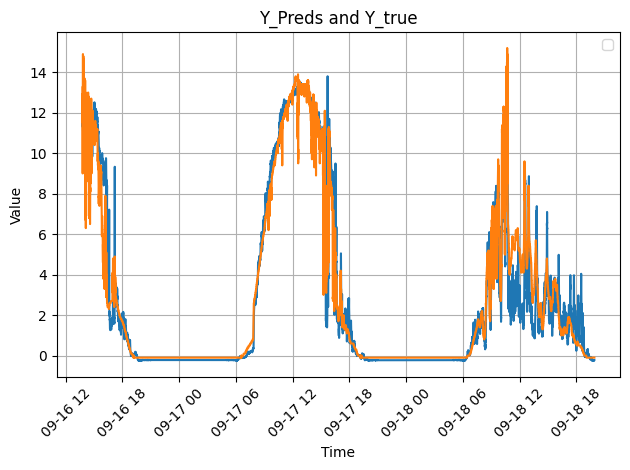

In [25]:
plt.plot(df_val['datetime'][:13724],y_preds)
plt.plot(df_val['datetime'][:13724],y_trues)
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.title('Y_Preds and Y_true')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
torch.save(model.state_dict(), "model.pth")